In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
from wordcloud import WordCloud
import pickle as pk

[nltk_data] Downloading package stopwords to /Users/aryal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/aryal/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Read the dataframe
df = pd.read_csv('IMDB Dataset.csv')

In [3]:
# View the first few rows
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
# Check column names and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [5]:
# Check summary statistics of the columns
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [6]:
# Check for missing values
df.isnull().sum()

review       0
sentiment    0
dtype: int64

In [7]:
# Check the number of negative and positive reviews
df['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [8]:
# Define function to stem and lemmatize the sentiment texts
def preprocess_text(text):
    
    # Define lemmatizer object
    lemmatizer = WordNetLemmatizer() 
    
    text = text.lower() # Converts all to lowercase
    text = re.sub(r'<br />', r'', text) # Removes HTML tags '<br /'
    text = re.sub(r'\d+', r'', text) # Removes numeric values 
    text = re.sub(r'[^\w\s]', r'', text) # Removes punctuations (keeping spaces)
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces    
    
    words = word_tokenize(text) #Splits text into words

    # Define a set of english stopwords
    stop_words = set(stopwords.words('english')) 
    
    # Remove stop words and apply lemmatization
    filtered_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    
    return filtered_words  # Return cleaned tokens

In [9]:
# Create a new column cleaned_reviews after processing the review column
df['cleaned_reviews'] = df['review'].apply(preprocess_text)

# Display sample output
df['cleaned_reviews'].head()

0    [one, reviewer, mentioned, watching, oz, episo...
1    [wonderful, little, production, filming, techn...
2    [thought, wonderful, way, spend, time, hot, su...
3    [basically, there, family, little, boy, jake, ...
4    [petter, matteis, love, time, money, visually,...
Name: cleaned_reviews, dtype: object

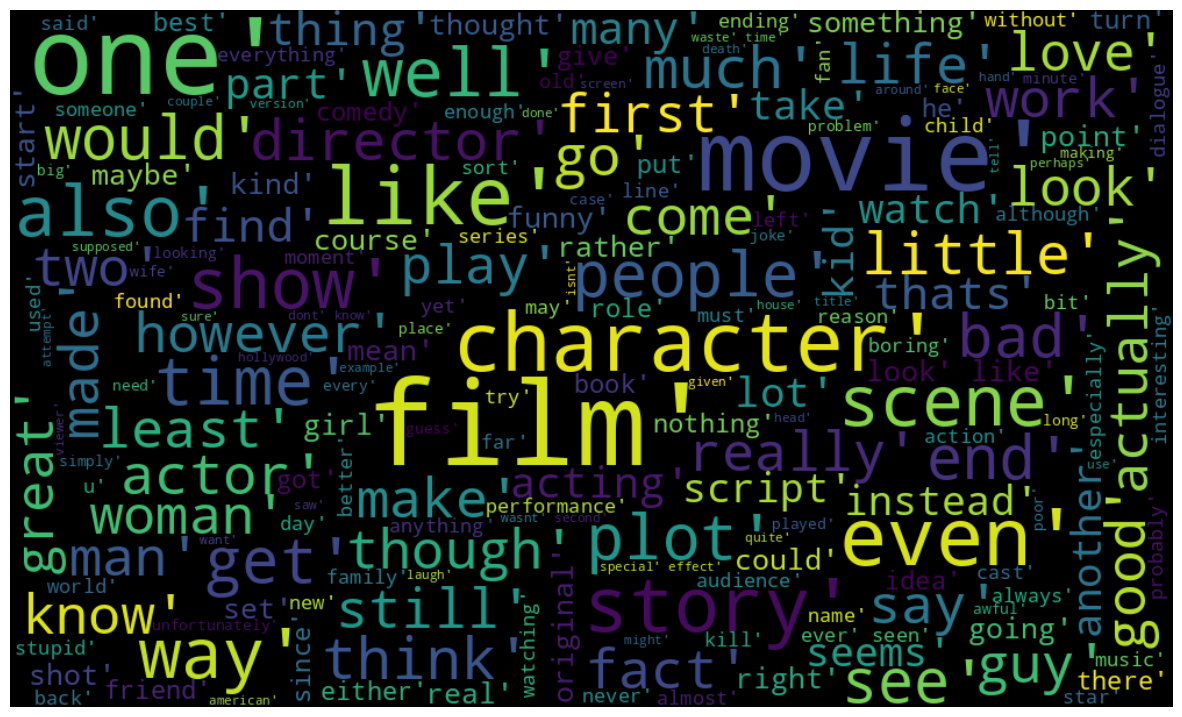

In [10]:
reviews = ' '.join(word for word in df['cleaned_reviews'][df['sentiment'] == 'negative'].astype(str))
wordcloud = WordCloud(height = 600, width = 1000, max_font_size = 100)
plt.figure(figsize = (15,12))
plt.imshow(wordcloud.generate(reviews), interpolation = 'bilinear')
plt.axis('off')
plt.show()

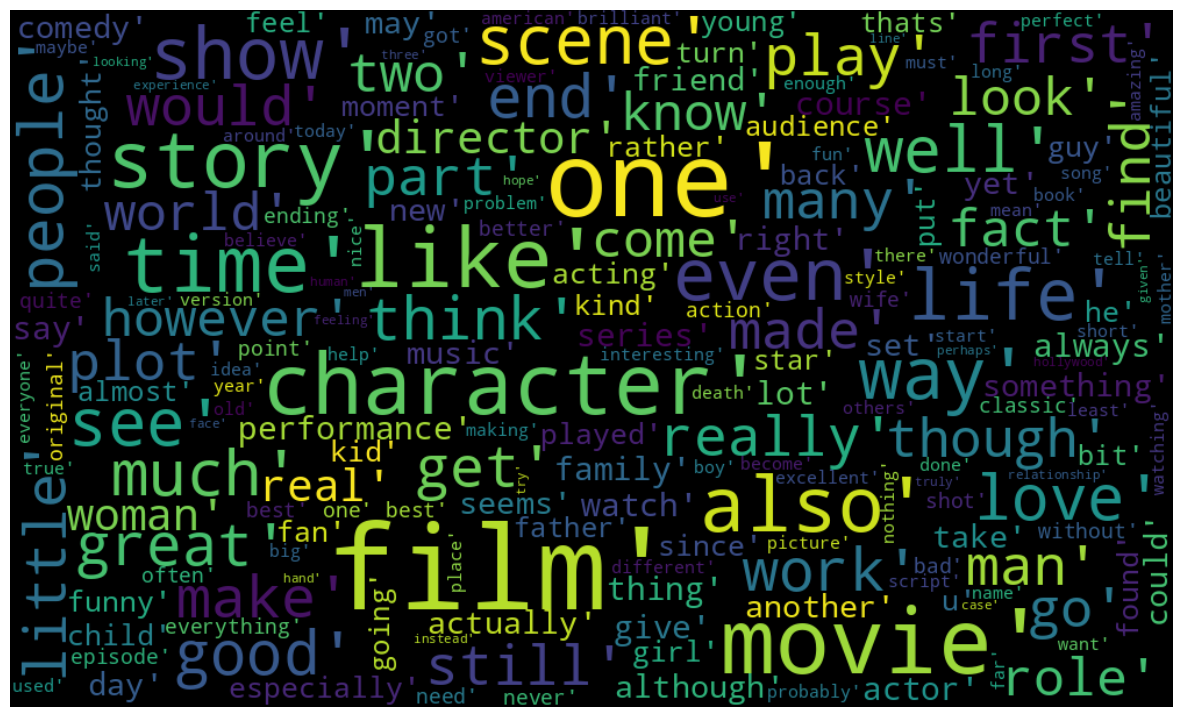

In [11]:
reviews = ' '.join(word for word in df['cleaned_reviews'][df['sentiment'] == 'positive'].astype(str))
wordcloud = WordCloud(height = 600, width = 1000, max_font_size = 100)
plt.figure(figsize = (15,12))
plt.imshow(wordcloud.generate(reviews), interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [12]:
# Convert list back to strings
df['cleaned_reviews'] = df['cleaned_reviews'].apply(lambda x: ' '.join(x))

# Apply TF-IDF vectorization
tfidf = TfidfVectorizer(max_features = 5000)
X = tfidf.fit_transform(df['cleaned_reviews'])

In [13]:
# Convert sentiments to 0 and 1
y = df['sentiment'].map({'positive':1, 'negative':0})

In [14]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# Train the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [16]:
# Predict sentiment (y) and then display accuracy and classification report
y_pred = model.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('CLassification Report:\n', classification_report(y_test, y_pred))

Accuracy: 0.8847
CLassification Report:
               precision    recall  f1-score   support

           0       0.89      0.87      0.88      4961
           1       0.88      0.90      0.89      5039

    accuracy                           0.88     10000
   macro avg       0.89      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



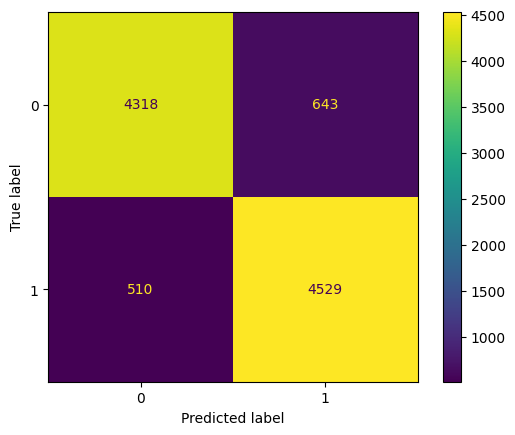

In [17]:
# Create confusion matrix to vizualize accuracy
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=model.classes_)
display.plot()
plt.show()

In [40]:
# Check prediction for a new data
review = "The movie is boring!"
processed_review = preprocess_text(review)
processed_review = ' '.join(processed_review)
transformed_text = tfidf.transform([processed_review])
prediction = model.predict(transformed_text)
print("Prediction:", "Positive" if prediction[0] == 1 else "Negative")

Prediction: Negative


In [38]:
pk.dump(model, open('model.pkl', 'wb'))
pk.dump(tfidf, open('tfidf.pkl', 'wb'))